In [1]:
# prerequisites
# https://github.com/lyeoni/pytorch-mnist-GAN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.nn.functional import pdist
import torchvision

import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# For this workbook, I want to promote class-diversity in GANs by adding a supervisor network which penalizes the Generators predictions for monotony. We can try things like taking samples from different points in latent space in order to assure they are diverse, which should lead to diverse decoded samples. 
The supervisor network is necessary since we do not have labels for generated images. The supervisor network is trained on MNIST and will label generated images. The generator is penalized if some proportion of decoded images are of the same predicted class.

In [44]:
bs = 50 #100
n_samples = 500 # set at 1000, a potential breakpoint for mode collapse
tr_split_len = n_samples
te_split_len = n_samples

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

part_tr = torch.utils.data.random_split(train_dataset, [tr_split_len, len(train_dataset)-tr_split_len])[0]
part_te = torch.utils.data.random_split(test_dataset, [te_split_len, len(test_dataset)-te_split_len])[0]

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=part_tr, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=part_te, batch_size=bs, shuffle=False)

In [45]:
print(type(train_dataset))
print(train_dataset)

print(type(train_loader))
print(train_loader)

print(len(train_loader.dataset))

<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
<class 'torch.utils.data.dataloader.DataLoader'>
500


# Normal Referee GAN

In [46]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print('x', x.shape)
        #print('flogs.s', F.log_softmax(x).shape)
        #print('flogs.s0.shape', F.log_softmax(x, dim=0).shape)
        return F.log_softmax(x,dim=0)

C:\Users\Alex\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 3.9209, Accuracy: 26/500 (5%)

Train Epoch: 1 [0/500 (0%)]	Loss: 3.934277

Test set: Avg. loss: 3.9159, Accuracy: 35/500 (7%)

Train Epoch: 2 [0/500 (0%)]	Loss: 3.949476

Test set: Avg. loss: 3.9109, Accuracy: 54/500 (11%)

Train Epoch: 3 [0/500 (0%)]	Loss: 3.905421

Test set: Avg. loss: 3.9073, Accuracy: 75/500 (15%)

Train Epoch: 4 [0/500 (0%)]	Loss: 3.910038

Test set: Avg. loss: 3.9025, Accuracy: 108/500 (22%)

Train Epoch: 5 [0/500 (0%)]	Loss: 3.914873

Test set: Avg. loss: 3.8993, Accuracy: 126/500 (25%)

Train Epoch: 6 [0/500 (0%)]	Loss: 3.919464

Test set: Avg. loss: 3.8954, Accuracy: 150/500 (30%)

Train Epoch: 7 [0/500 (0%)]	Loss: 3.895697

Test set: Avg. loss: 3.8905, Accuracy: 172/500 (34%)

Train Epoch: 8 [0/500 (0%)]	Loss: 3.877763

Test set: Avg. loss: 3.8852, Accuracy: 196/500 (39%)

Train Epoch: 9 [0/500 (0%)]	Loss: 3.882651

Test set: Avg. loss: 3.8787, Accuracy: 208/500 (42%)

Train Epoch: 10 [0/500 (0%)]	Loss: 3.887233

Test set: Avg. loss: 3.8


Test set: Avg. loss: 2.2314, Accuracy: 439/500 (88%)

Train Epoch: 84 [0/500 (0%)]	Loss: 2.244319

Test set: Avg. loss: 2.2206, Accuracy: 442/500 (88%)

Train Epoch: 85 [0/500 (0%)]	Loss: 2.354840

Test set: Avg. loss: 2.2097, Accuracy: 445/500 (89%)

Train Epoch: 86 [0/500 (0%)]	Loss: 2.436416

Test set: Avg. loss: 2.2069, Accuracy: 441/500 (88%)

Train Epoch: 87 [0/500 (0%)]	Loss: 2.304988

Test set: Avg. loss: 2.2161, Accuracy: 440/500 (88%)

Train Epoch: 88 [0/500 (0%)]	Loss: 2.250477

Test set: Avg. loss: 2.1971, Accuracy: 443/500 (89%)

Train Epoch: 89 [0/500 (0%)]	Loss: 2.379162

Test set: Avg. loss: 2.1945, Accuracy: 444/500 (89%)

Train Epoch: 90 [0/500 (0%)]	Loss: 2.222795

Test set: Avg. loss: 2.1912, Accuracy: 445/500 (89%)

Train Epoch: 91 [0/500 (0%)]	Loss: 2.503625

Test set: Avg. loss: 2.1880, Accuracy: 445/500 (89%)

Train Epoch: 92 [0/500 (0%)]	Loss: 2.238864

Test set: Avg. loss: 2.1797, Accuracy: 445/500 (89%)

Train Epoch: 93 [0/500 (0%)]	Loss: 2.366808

Test set:

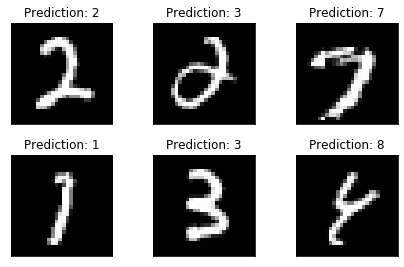

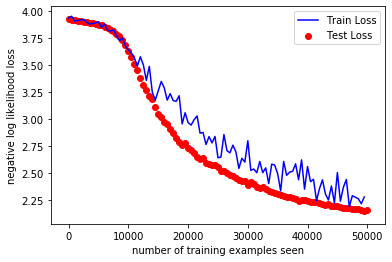

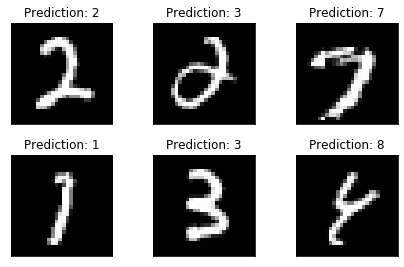

In [47]:


examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

n_epochs = 100 #300
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(data.shape)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
          #torch.save(network.state_dict(), '/results/model.pth')
          #torch.save(optimizer.state_dict(), '/results/optimizer.pth')
    
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

with torch.no_grad():
    output = network(example_data.to(device))

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
      output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

# Now we have a trained supervisor network.
We will use this to create penalty terms on our G

In [88]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)
target_dim = 10

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [89]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [90]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [91]:
# loss
criterion = nn.BCELoss() 
# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)


In [92]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [93]:
def G_train(x, penalty = 'none', alpha = .01):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)
    
    if penalty == 'diverse':
        pen = check_diversity()
        #print(pen)
        G_loss = G_loss + alpha*pen

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [94]:
def check_diversity(penalty = 'distrib'):
    z = Variable(torch.randn(bs, z_dim).to(device))
    G_output = G(z)
    reshaped_G_output = G_output.reshape(G_output.shape[0], 1, 28, 28) # row to torch.Size([50, 1, 28, 28])
    #print(reshaped_G_output.shape)
    output = network(reshaped_G_output).cpu()
    
    output = torch.sigmoid(output)
    
    #print(output.shape)
    
    #pred = output.data.max(1, keepdim=True)[1].T
    #print(pred.shape)
    #print(pred)
    #print(pred_labels)
    
    if penalty == 'distrib':
        # here is the penalty for distribution of classes vs.expected distribution of classes
        natural_distrib = torch.Tensor(bs, target_dim).fill_(1/target_dim).cpu()
        #print(natural_distrib.shape)
        #print(output.device, output.shape)
        #print(natural_distrib.device, natural_distrib.shape)
        penalty = criterion(output, natural_distrib)
        
    if penalty == 'square':
        # the square penalty should incentivize dispursed samples because of the nonlinear transform
        pass
    #print(penalty)
    # here is a harsh penalty on a more mode-collapse setting where almost all the classes are the same
    #pred_labels.sum()**2 # something like, penalty gets much bigger (n^2) as the single-class density gets bigger
        
    return penalty.to(device)

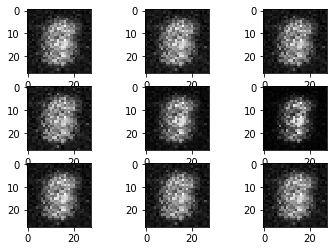

tensor([[2, 0, 6, 0, 7, 7, 7, 6, 0]], device='cuda:0')
[200/1000]: loss_d: 0.716, loss_g: 2.151


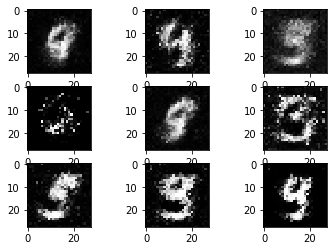

tensor([[6, 4, 5, 2, 7, 3, 5, 3, 9]], device='cuda:0')
[400/1000]: loss_d: 0.612, loss_g: 3.570


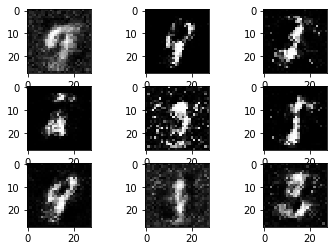

tensor([[5, 4, 2, 6, 7, 1, 4, 1, 3]], device='cuda:0')
[600/1000]: loss_d: 0.595, loss_g: 2.496


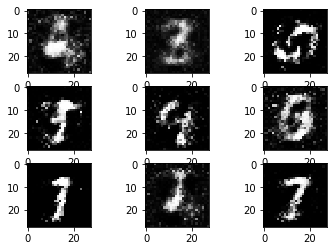

tensor([[6, 3, 0, 1, 9, 5, 7, 2, 7]], device='cuda:0')
[800/1000]: loss_d: 0.605, loss_g: 2.624


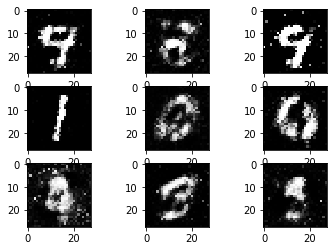

tensor([[9, 8, 9, 1, 2, 6, 7, 5, 3]], device='cuda:0')
[1000/1000]: loss_d: 0.564, loss_g: 2.916


In [95]:
n_epoch = 1000
print_stride = n_epoch//5
alpha = .03

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x, penalty = 'diverse', alpha = alpha))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z)
                
                output = network(generated.reshape(generated.shape[0], 1, 28, 28))
                
                pred = output.data.max(1, keepdim=True)[1]

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28).cpu()
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                
                print(pred.T)
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), f'./samples/sample_{n_samples}' + '.png')

In [ ]:
for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()

## Normal GAN - Inserting lipschitz into it at problem areas

In [ ]:
def lip_pen_batch(enc, dec):
    # given a n-batch of encoded points and their decoded representation
    # compute the mean pairwise distance in encoded space over decoded space
    # pairwise distances given by upper triangle (non diagonal) of proximity matrix
    numer = torch.mean(pdist(enc, p=2))
    denom = torch.mean(pdist(dec, p=2))
    new_pen = numer/denom
    return new_pen, numer, denom

def lip_pen_pair(enc, dec, perm):
    #iterations = enc.shape[0]
    iterations = 20
    pen_list, numer_list, denom_list = [], [], []
    
    pen_list = torch.zeros(iterations)
    #print(pen_list.shape)
    
    for i in range(iterations):
        #print(i)
        idx = perm[:2]
        
        numer_sample_2 = dec[idx]
        numer = torch.dist(numer_sample_2[0,], numer_sample_2[1,], p=2)
        #print(numer)
        numer_list.append(numer)
        
        denom_sample_2 = enc[idx]
        denom = torch.dist(denom_sample_2[0,], denom_sample_2[1,], p=2)
        #print('denom', denom)
        denom_list.append(denom)
        
        pair_pen = 1 - (numer / denom)
        #print('pair_pen', pair_pen)
        pen_list[i] = pair_pen
        #print(pen_list[i])

    #print(torch.mean(pen_list).device)
    
    return torch.mean(pen_list).to(device)#, torch.mean(torch.tensor(numer_list)), torch.mean(torch.tensor(denom_list))
    
def nu_pen_batch(enc, dec):
    # 
    
    numer = torch.mean(pdist(enc, p=2))
    denom = torch.mean(pdist(dec, p=2))
    new_pen = (1 - numer/denom)
    return new_pen, numer, denom

def nu_pen_pair(enc, dec):
    # given a n-batch of encoded points and their decoded representation
    # compute the mean pairwise distance in encoded space over decoded space
    # pairwise distances given by upper triangle (non diagonal) of proximity matrix
    numer = torch.mean(pdist(enc, p=2))
    denom = torch.mean(pdist(dec, p=2))
    new_pen = numer/denom
    return new_pen, numer, denom

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
def G_train(x, penalty = 'none', alpha = 0, perm = None):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)
    
    if penalty == 'pair_lipschitz':
        perm = torch.randperm(x.size(0))
        pen = lip_pen_pair(z, G_output, perm)
        G_loss = G_loss + alpha*pen
    
    if penalty == 'batch_lipschitz':
        pen, numer, denom = lip_pen_batch(z, G_output)
        G_loss = G_loss + alpha*pen
        
    if penalty == 'pair_nu':
        perm = torch.randperm(enc.size(0))
        pen, numer, denom = nu_pen_pair(z, G_output, perm)
        G_loss = G_loss + alpha*pen
    
    if penalty == 'batch_nu':
        pen, numer, denom = nu_pen_batch(z, G_output)
        G_loss = G_loss + alpha*pen

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# loss and penalty
criterion = nn.BCELoss()
alpha = .4

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 4000 #4000
print_stride = 20

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x, penalty = 'pair_lipschitz', alpha = alpha))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

## Relative Discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class RelDiscriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(RelDiscriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return self.fc4(x) # needs linear output

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
RD = RelDiscriminator(mnist_dim).to(device)

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
RD_optimizer = optim.Adam(RD.parameters(), lr = lr)

In [ ]:
G

In [ ]:
RD

In [ ]:
# TAKEN FROM ANOTEHR

def RD_train(x_r):
    RD.zero_grad()
    x_r = Variable(x_r.view(-1, mnist_dim).to(device))

    latent_samples = Variable(torch.randn(bs, z_dim)).to(device)
    x_f = G(latent_samples)

    sout = torch.sigmoid(RD(x_r) - RD(x_f))# where C is some discrim with LINEAR OUTPUT
    RD_loss = -torch.mean(torch.log(sout))
    
    RD_loss.backward() #retain_graph=True
    RD_optimizer.step()
        
    return  RD_loss.data.item()

# For paper recreation
def RD_G_train(x_r):
    G.zero_grad()
    x_r = Variable(x_r.view(-1, mnist_dim).to(device))


    # My code
    latent_samples = Variable(torch.randn(bs, z_dim)).to(device)
    x_f = G(latent_samples)
    
    sout = torch.sigmoid(RD(x_f) - RD(x_r))

    G_loss = -torch.mean(torch.log(sout))
    
    # gradient backprop & optimize ONLY G's parameters
    
    G_loss.backward() #retain_graph=True
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 2000
print_stride = 20

for epoch in range(1, n_epoch+1):           
    RD_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        RD_losses.append(RD_train(x))
        G_losses.append(RD_G_train(x))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(RD_losses)), torch.mean(torch.FloatTensor(G_losses))))

## Referee (and split referee) Discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Referee(nn.Module):
    def __init__(self, r_input_dim):
        super(Referee, self).__init__()
        self.fc1 = nn.Linear(r_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, left, right):
        x = torch.cat((left, right), 1)
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, r_dropout)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, r_dropout)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, r_dropout)
        return torch.sigmoid(self.fc4(x))

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
R = Referee(mnist_dim*2).to(device)

r_dropout = 0.4 #.3

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
R_optimizer = optim.Adam(R.parameters(), lr = lr)

In [ ]:
G

In [ ]:
R

In [ ]:
# TAKEN FROM ANOTEHR

def R_train(x):
    R.zero_grad()
    
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_f, y_f = G(z), Variable(torch.ones(bs, 1).to(device))

    # train referee on real in 0th index
    x_r, y_r = x.view(-1, mnist_dim), torch.zeros(bs, 1)
    x_r, y_r = Variable(x_r.to(device)), Variable(y_r.to(device))

    R_output = R(x_r, x_f)
    R_real_loss = criterion(R_output, y_r)

    # train referee on real in 1th index
    R_output = R(x_f, x_r)
    R_fake_loss = criterion(R_output, y_f)

    # gradient backprop & optimize ONLY D's parameters
    R_loss = R_real_loss + R_fake_loss
    R_loss.backward()
    R_optimizer.step()
        
    return  R_loss.data.item()

# For paper recreation
def R_G_train(x_r):
    G.zero_grad()
    
    x_r = Variable(x_r.view(-1, mnist_dim).to(device))
    latent_samples = Variable(torch.randn(bs, z_dim)).to(device)
    x_f = G(latent_samples)
    ones = Variable(torch.ones(bs, 1).to(device))
    
    R_output = R(x_r, x_f) #ref wants this to be 0, g wants this to be 1

    G_loss = criterion(R_output, ones) # G loss low when R_output near 1
    
    # gradient backprop & optimize ONLY G's parameters
    
    G_loss.backward() #retain_graph=True
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 200
print_stride = 1

for epoch in range(1, n_epoch+1):           
    R_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        R_losses.append(R_train(x))
        G_losses.append(R_G_train(x))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(R_losses)), torch.mean(torch.FloatTensor(G_losses))))

In [ ]:
    
class Supervisor(nn.Module):
    def __init__(self, s_input_dim, s_output_dim):
        super(Supervisor, self).__init__()
        self.fc1 = nn.Linear(s_input_dim, 512)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, s_output_dim)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        #x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        #x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        #x = F.dropout(x, 0.3)
        return torch.softmax(self.fc4(x), dim = 1)